# Jigsaw Multilingual Toxic Comment Classification

It only takes one toxic comment to sour an online discussion. The Conversation AI team, a research initiative founded by Jigsaw and Google, builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion. If these toxic contributions can be identified, we could have a safer, more collaborative internet.

In the previous 2018 Toxic Comment Classification Challenge, Kagglers built multi-headed models to recognize toxicity and several subtypes of toxicity. In 2019, in the Unintended Bias in Toxicity Classification Challenge, you worked to build toxicity models that operate fairly across a diverse range of conversations. This year, we're taking advantage of Kaggle's new TPU support and challenging you to build multilingual models with English-only training data.

Jigsaw's API, Perspective, serves toxicity models and others in a growing set of languages (see our documentation for the full list). Over the past year, the field has seen impressive multilingual capabilities from the latest model innovations, including few- and zero-shot learning. We're excited to learn whether these results "translate" (pun intended!) to toxicity classification. Your training data will be the English data provided for our previous two competitions and your test data will be Wikipedia talk page comments in several different languages.

As our computing resources and modeling capabilities grow, so does our potential to support healthy conversations across the globe. Develop strategies to build effective multilingual models and you'll help Conversation AI and the entire industry realize that potential.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import re
import folium
import textstat
from scipy import stats
from colorama import Fore, Back, Style, init

import math
import numpy as np
import scipy as sp
import pandas as pd

import random
import networkx as nx
from pandas import Timestamp

from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot

import requests
from IPython.display import HTML

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt

tqdm.pandas()

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

#import transformers
import tensorflow as tf

from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from tensorflow.keras.models import Model
#from kaggle_datasets import KaggleDatasets
#from tensorflow.keras.optimizers import Adam
#from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import LSTM, GRU, Conv1D, SpatialDropout1D

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.constraints import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *

from sklearn import metrics
from sklearn.utils import shuffle
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer,\
                                            CountVectorizer,\
                                            HashingVectorizer

from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer  

import nltk
from textblob import TextBlob

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from googletrans import Translator
from nltk import WordNetLemmatizer
#from polyglot.detect import Detector
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer

stopword=set(STOPWORDS)

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

np.random.seed(0)

# Load the training, validation, and testing datasets


In [13]:

val_data = pd.read_csv("validation.csv")
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("jigsaw-toxic-comment-train.csv")

In [14]:
train_data.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [13]:
test_data.head()

id                                            content lang
0   0  Doctor Who adlı viki başlığına 12. doctor olar...   tr
1   1   Вполне возможно, но я пока не вижу необходимо...   ru
2   2  Quindi tu sei uno di quelli   conservativi  , ...   it
3   3  Malesef gerçekleştirilmedi ancak şöyle bir şey...   tr
4   4  :Resim:Seldabagcan.jpg resminde kaynak sorunu ...   tr

In [14]:
val_data.head()

id                                       comment_text lang  toxic
0   0  Este usuario ni siquiera llega al rango de    ...   es      0
1   1  Il testo di questa voce pare esser scopiazzato...   it      0
2   2  Vale. Sólo expongo mi pasado. Todo tiempo pasa...   es      1
3   3  Bu maddenin alt başlığı olarak  uluslararası i...   tr      0
4   4  Belçika nın şehirlerinin yanında ilçe ve belde...   tr      0

In [15]:
train_data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
id               223549 non-null object
comment_text     223549 non-null object
toxic            223549 non-null int64
severe_toxic     223549 non-null int64
obscene          223549 non-null int64
threat           223549 non-null int64
insult           223549 non-null int64
identity_hate    223549 non-null int64
dtypes: int64(6), object(2)
memory usage: 13.6+ MB


In [17]:
train_data.shape

(223549, 8)

In [18]:
train_data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

# TOXIC

In [10]:
train_data["toxic"].value_counts()

0    202165
1     21384
Name: toxic, dtype: int64

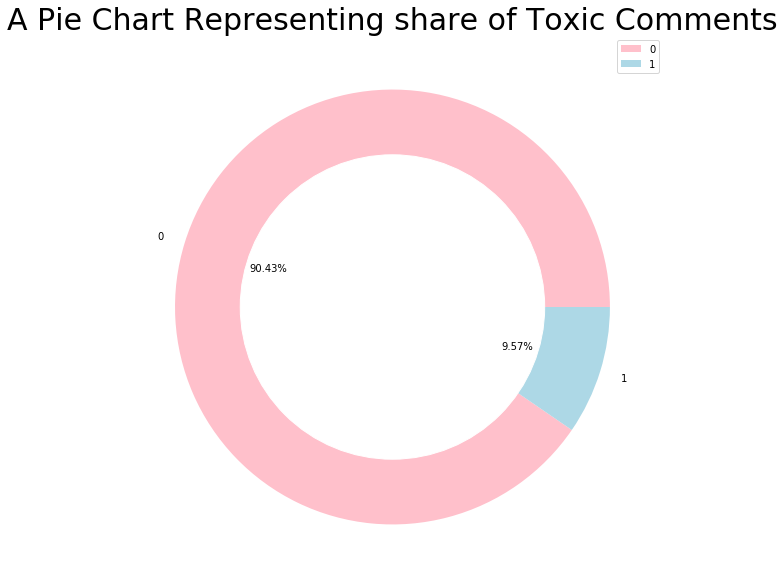

In [11]:
# making a donut chart to represent share of each.

size = [202165, 21384]
colors = ['pink', 'lightblue']
labels = "0","1"

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%')
plt.axis('off')
plt.title('A Pie Chart Representing share of Toxic Comments', fontsize = 30)
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.legend()
plt.show()

# Words cloud of Negative toxic sentiments

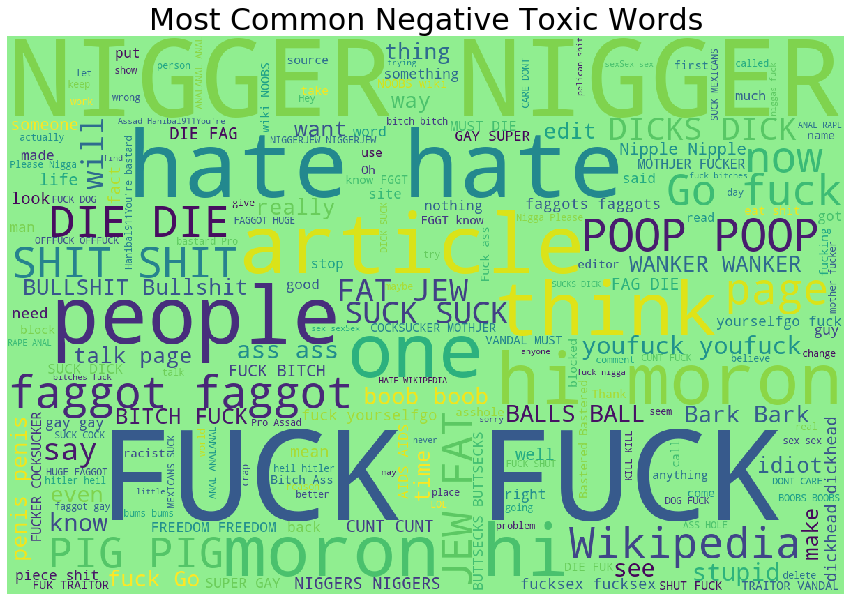

In [12]:


Negative_sentiments = " ".join([text for text in train_data['comment_text'][train_data['toxic'] == 1]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'lightgreen', stopwords = stopwords, width = 1200, height = 800).generate(Negative_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Negative Toxic Words', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# Words cloud of Positive sentiments

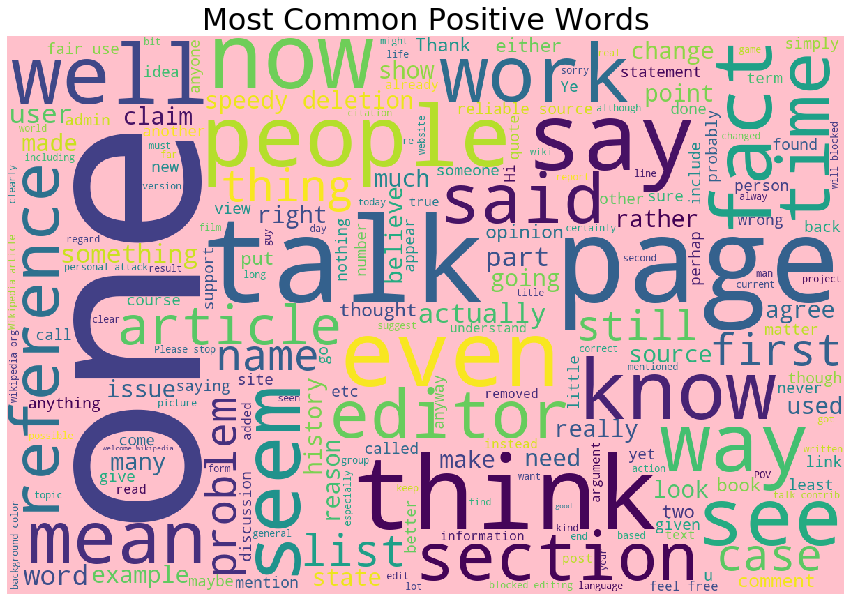

In [13]:
# making Words cloud for the postive sentiments

Positive_sentiments = " ".join([text for text in train_data['comment_text'][train_data['toxic'] == 0]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'pink', stopwords = stopwords, width = 1200, height = 800).generate(Positive_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Positive Words', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# SEVERE TOXIC

In [14]:
train_data["severe_toxic"].value_counts()

0    221587
1      1962
Name: severe_toxic, dtype: int64

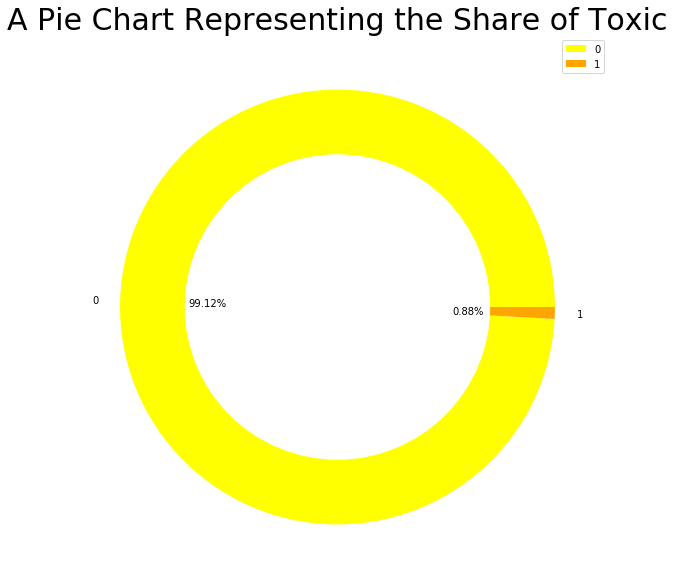

In [15]:
# making a donut chart to represent share of each ratings

size = [221587, 1962]
colors = ['yellow', 'orange']
labels = "0","1"

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%')
plt.axis('off')
plt.title('A Pie Chart Representing the Share of Toxic', fontsize = 30)
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.legend()
plt.show()

#  Words cloud for Negative severe_toxic sentiments

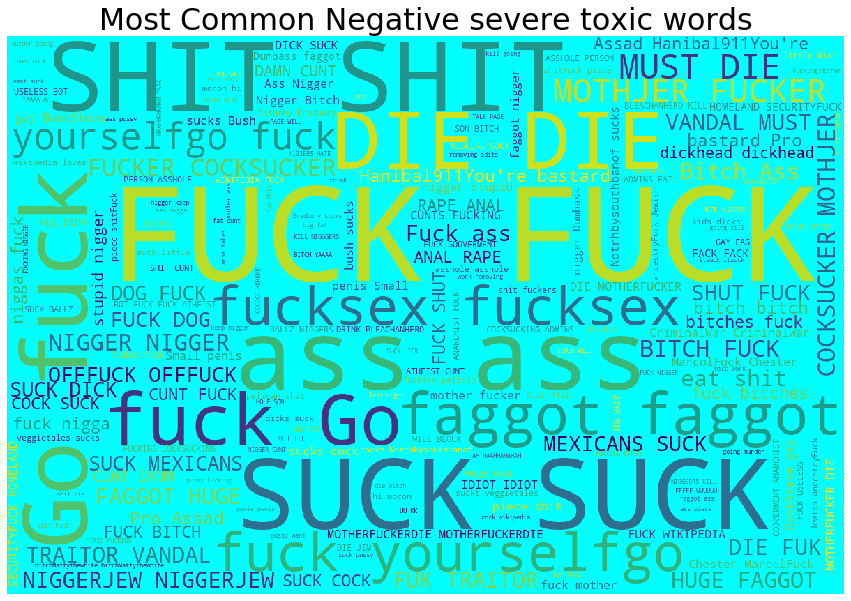

In [16]:


Negative_sentiments = " ".join([text for text in train_data['comment_text'][train_data['severe_toxic'] == 1]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'cyan', stopwords = stopwords, width = 1200, height = 800).generate(Negative_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Negative severe toxic words', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# Postive sentiments

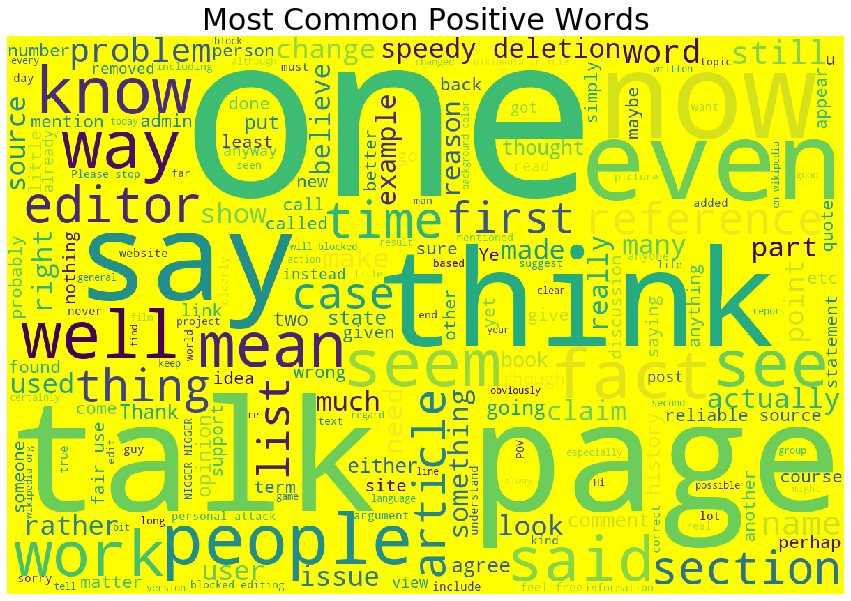

In [17]:


Positive_sentiments = " ".join([text for text in train_data['comment_text'][train_data['severe_toxic'] == 0]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'yellow', stopwords = stopwords, width = 1200, height = 800).generate(Positive_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Positive Words', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# Obscene

In [18]:
train_data["obscene"].value_counts()

0    211409
1     12140
Name: obscene, dtype: int64

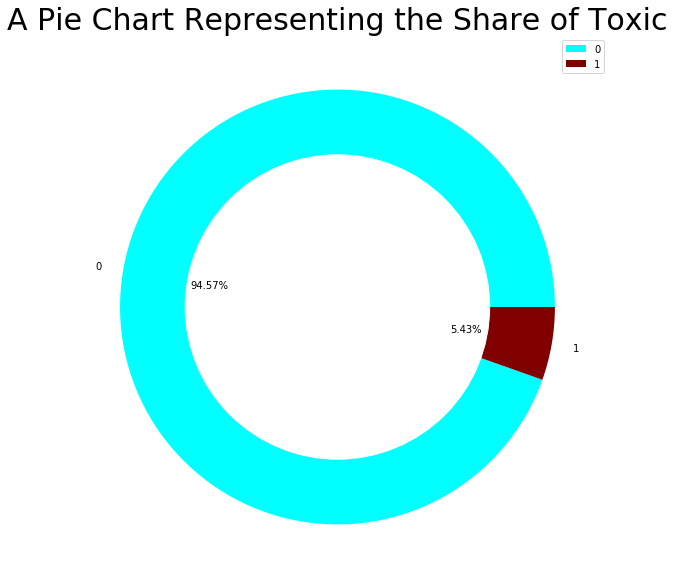

In [19]:
# making a donut chart to represent share of each ratings

size = [211409, 12140]
colors = ['cyan', 'maroon']
labels = "0","1"

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%')
plt.axis('off')
plt.title('A Pie Chart Representing the Share of Toxic', fontsize = 30)
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.legend()
plt.show()

#  Words cloud for the Negative Obscene words

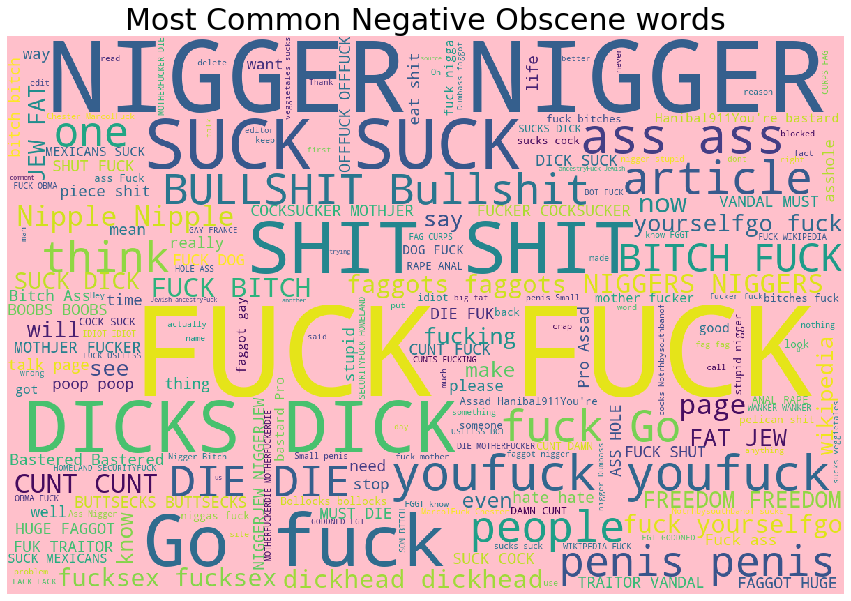

In [20]:


Negative_sentiments = " ".join([text for text in train_data['comment_text'][train_data["obscene"] == 1]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'pink', stopwords = stopwords, width = 1200, height = 800).generate(Negative_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Negative Obscene words', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# Postive sentiments

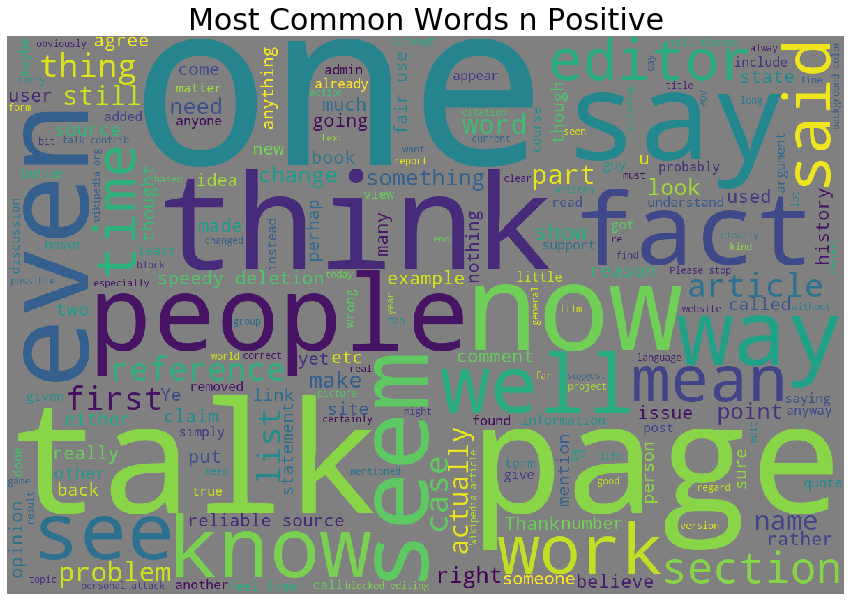

In [21]:


Positive_sentiments = " ".join([text for text in train_data['comment_text'][train_data["obscene"] == 0]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'grey', stopwords = stopwords, width = 1200, height = 800).generate(Positive_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Words n Positive', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# THREAT

In [22]:
train_data["threat"].value_counts()

0    222860
1       689
Name: threat, dtype: int64

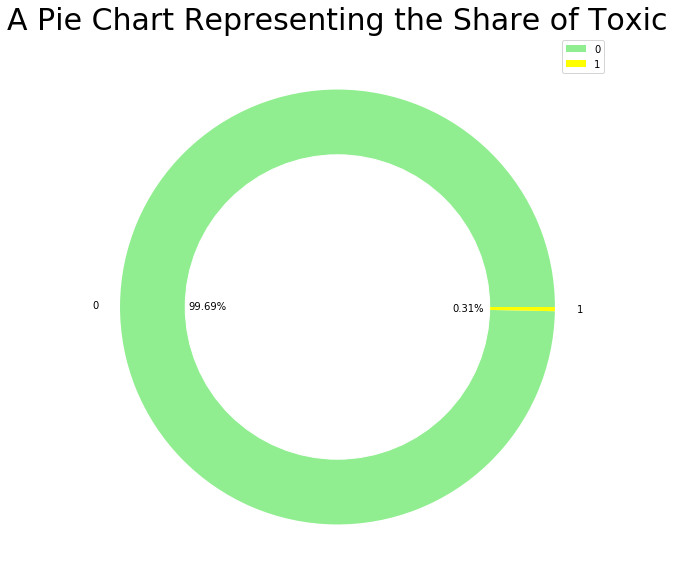

In [23]:
# making a donut chart to represent share of each ratings

size = [222860,  689]
colors = ['lightgreen', 'yellow']
labels = "0","1"

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%')
plt.axis('off')
plt.title('A Pie Chart Representing the Share of Toxic', fontsize = 30)
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.legend()
plt.show()

#  Words cloud for the Negative THreat words

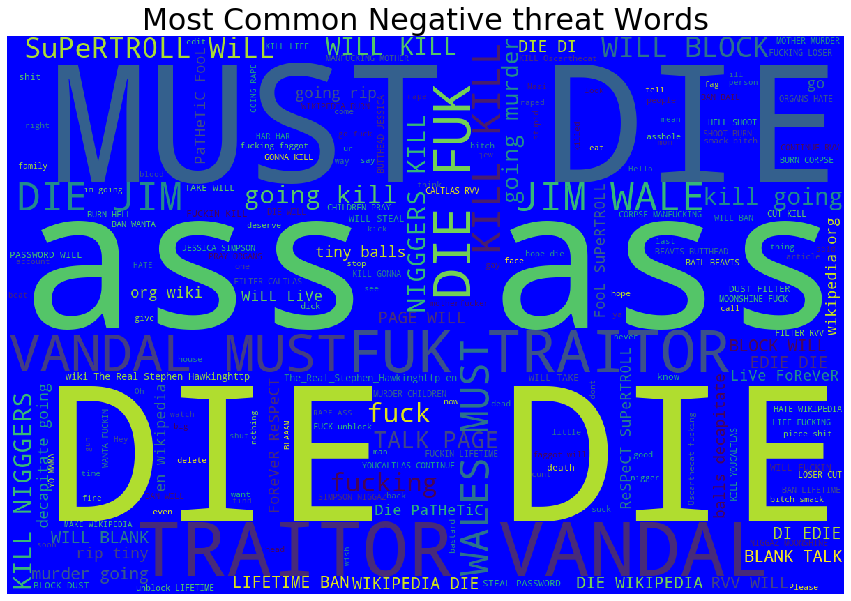

In [24]:


Negative_sentiments = " ".join([text for text in train_data['comment_text'][train_data["threat"] == 1]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'blue', stopwords = stopwords, width = 1200, height = 800).generate(Negative_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Negative threat Words', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# Postive sentiments

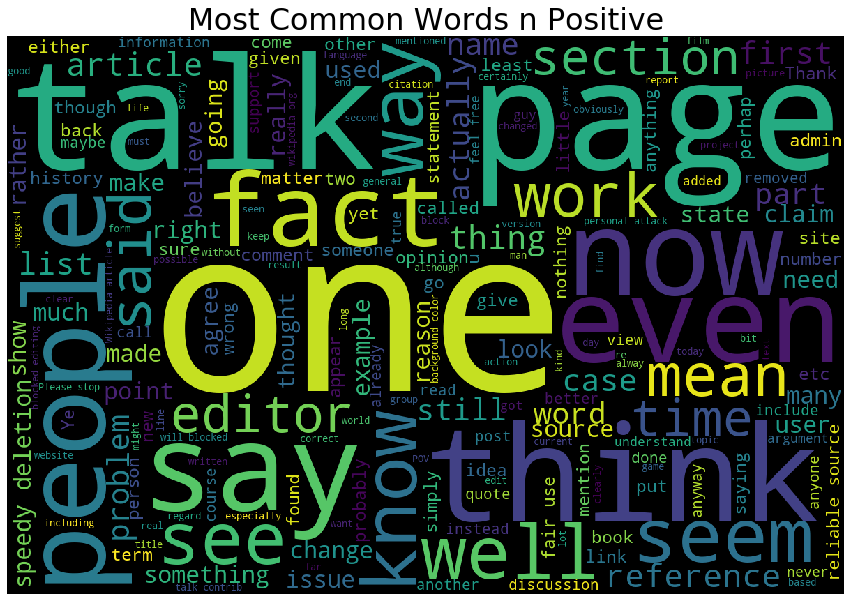

In [25]:


Positive_sentiments = " ".join([text for text in train_data['comment_text'][train_data["obscene"] == 0]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'black', stopwords = stopwords, width = 1200, height = 800).generate(Positive_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Words n Positive', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# IDENTITY HATE

In [26]:
train_data["identity_hate"].value_counts()

0    221432
1      2117
Name: identity_hate, dtype: int64

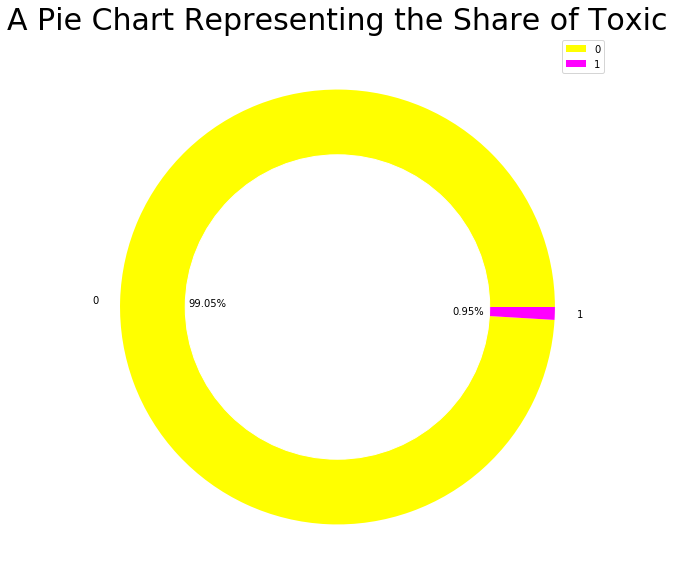

In [27]:
# making a donut chart to represent share of each ratings

size = [221432,   2117]
colors = ['yellow', 'magenta']
labels = "0","1"

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%')
plt.axis('off')
plt.title('A Pie Chart Representing the Share of Toxic', fontsize = 30)
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.legend()
plt.show()

# Words cloud for NEGATIVE HATE WORDS

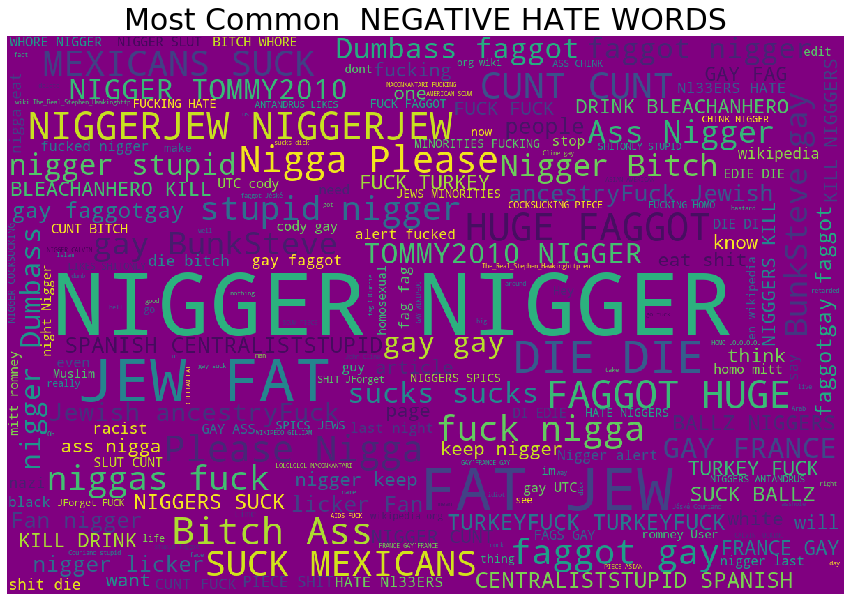

In [28]:


Negative_sentiments = " ".join([text for text in train_data['comment_text'][train_data['identity_hate'] == 1]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'purple', stopwords = stopwords, width = 1200, height = 800).generate(Negative_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common  NEGATIVE HATE WORDS', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

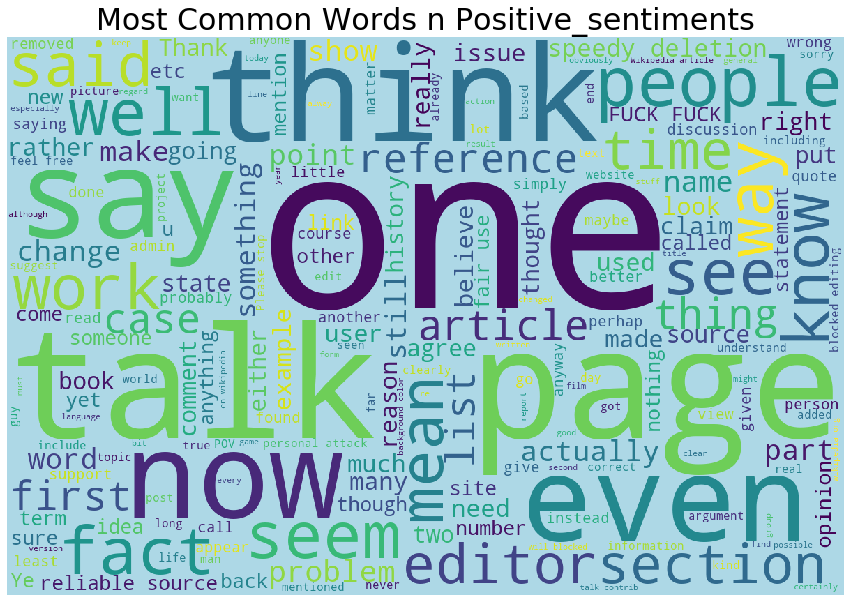

In [29]:
# Postive sentiments

Positive_sentiments = " ".join([text for text in train_data['comment_text'][train_data['identity_hate'] == 0]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'lightblue', stopwords = stopwords, width = 1200, height = 800).generate(Positive_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Words n Positive_sentiments', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# Distribution of comment words

In [30]:
def new_len(x):
    if type(x) is str:
        return len(x.split())
    else:
        return 0

train_data["comment_words"] = train_data["comment_text"].apply(new_len)
nums = train_data.query("comment_words != 0 and comment_words < 200").sample(frac=0.1)["comment_words"]
fig = ff.create_distplot(hist_data=[nums],
                         group_labels=["All comments"],
                         colors=["black"])

fig.update_layout(title_text="Comment words", xaxis_title="Comment words", template="simple_white", showlegend=False)
fig.show()

In [31]:
fig = go.Figure(data=[
    go.Pie(labels=train_data.columns[2:7],
           values=train_data.iloc[:, 2:7].sum().values, marker=dict(colors=px.colors.qualitative.Plotly))
])
fig.update_traces(textposition='outside', textfont=dict(color="black"))
fig.update_layout(title_text="Pie chart of labels")
fig.show()

In [32]:
fig = go.Figure(data=[
    go.Bar(y=train_data.columns[2:7],
           x=train_data.iloc[:, 2:7].sum().values, marker=dict(color=px.colors.qualitative.Plotly))
])

fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.75
fig.update_traces(orientation="h")
fig.update_layout(title_text="Bar chart of labels", template="plotly_white")
fig.show()

In [15]:
val = val_data
train = train_data

def clean(text):
    text = text.fillna("fillna").str.lower()
    text = text.map(lambda x: re.sub('\\n',' ',str(x)))
    text = text.map(lambda x: re.sub("\[\[User.*",'',str(x)))
    text = text.map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    text = text.map(lambda x: re.sub("\(http://.*?\s\(http://.*\)",'',str(x)))
    return text

val["comment_text"] = clean(val["comment_text"])
test_data["content"] = clean(test_data["content"])
train["comment_text"] = clean(train["comment_text"])

# Modeling 
Deep learning models can be used to classify toxic comments

# ROC-AUC evaluation metric


In [16]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

# Function to tokenize 


In [17]:
def fast_encode(texts, tokenizer, chunk_size=240, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [18]:
from tokenizers import Tokenizer, Encoding
from tokenizers import decoders
from tokenizers import models
from tokenizers import normalizers
from tokenizers import pre_tokenizers
from tokenizers import processors
from tokenizers import trainers
from tokenizers import BertWordPieceTokenizer


In [19]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [20]:
train_data.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [21]:
train_data['comment_text'].apply(lambda x:len(str(x).split())).max()

2321

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

xtrain, xvalid, ytrain, yvalid = train_test_split(train_data.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [23]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

# Simple RNN

In [42]:
%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 300)         89929200  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 89,969,401
Trainable params: 89,969,401
Non-trainable params: 0
_________________________________________________________________
Wall time: 4.27 s


In [43]:
model.fit(xtrain_pad, ytrain, nb_epoch=5, batch_size=64*strategy.num_replicas_in_sync) 

Epoch 1/5
178839/178839 [==============================] - 7200s 40ms/step - loss: 0.2308 - accuracy: 0.9220
Epoch 2/5
178839/178839 [==============================] - 7044s 39ms/step - loss: 0.2010 - accuracy: 0.9321
Epoch 3/5
178839/178839 [==============================] - 7001s 39ms/step - loss: 0.1477 - accuracy: 0.9478
Epoch 4/5
178839/178839 [==============================] - 6814s 38ms/step - loss: 0.1505 - accuracy: 0.9490
Epoch 5/5
178839/178839 [==============================] - 9522s 53ms/step - loss: 0.1161 - accuracy: 0.9604


In [24]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [51]:

scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.88%


In [52]:
scores_model = []
scores_model.append({'Model': 'SimpleRNN','AUC_Score': roc_auc(scores,yvalid)})

# LTSM 

In [32]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|█████████████████████████████████████████████████████████████████████| 299763/299763 [00:00<00:00, 1297954.27it/s]


In [33]:
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 300)         89929200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 90,089,701
Trainable params: 160,501
Non-trainable params: 89,929,200
_________________________________________________________________
Wall time: 10 s


In [34]:
model.fit(xtrain_pad, ytrain, nb_epoch=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
178839/178839 [==============================] - 11532s 64ms/step - loss: 0.3179 - accuracy: 0.9043
Epoch 2/5
178839/178839 [==============================] - 10206s 57ms/step - loss: 0.3159 - accuracy: 0.9043
Epoch 3/5
178839/178839 [==============================] - 10177s 57ms/step - loss: 0.3158 - accuracy: 0.9043
Epoch 4/5
178839/178839 [==============================] - 15813s 88ms/step - loss: 0.3158 - accuracy: 0.9043
Epoch 5/5
178839/178839 [==============================] - 45900s 257ms/step - loss: 0.3158 - accuracy: 0.9043


In [36]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [37]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.50%


# The best auc_roc score is showed by RNN which is 88%